In [ ]:
# Install necessary libraries
!pip install kagglehub
!pip install opencv-python
!pip install scikit-learn
!pip install scikit-image

# Import required libraries
from IPython import get_ipython
from IPython.display import display
import os
import cv2
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from skimage.feature import hog
import matplotlib.pyplot as plt
import kagglehub

# Set seed for reproducibility
SEED = 9
np.random.seed(SEED)

# Function to extract features manually
def extract_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, _ = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm="L2-Hys"
    )
    edges = cv2.Canny(gray, 50, 150)
    edge_features = edges.flatten() / 255.0
    gray_features = gray.flatten() / 255.0
    return np.concatenate([hog_features, edge_features, gray_features])

# Function to load annotations
def load_annotations(annotations_file):
    with open(annotations_file, 'r') as f:
        data = json.load(f)
    annotations = []
    for item in data['images']:
        anns = [ann for ann in data['annotations'] if ann['image_id'] == item['id']]
        annotations.append({"file_name": item['file_name'], "annotations": anns})
    return annotations

# Prepare dataset by extracting features and bounding box coordinates
def prepare_dataset(annotations, image_dir):
    X = []
    y = []
    for record in annotations:
        img_path = os.path.join(image_dir, record['file_name'])

        if not os.path.exists(img_path):
            print(f"Missing Image: {img_path}")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue

        if len(record['annotations']) == 0:
            continue

        bbox = record['annotations'][0]['bbox']
        features = extract_features(image)

        X.append(features)
        y.append(bbox)

    return np.array(X), np.array(y)

# Download datasets using kagglehub
path1 = kagglehub.dataset_download("pkdarabi/bone-fracture-detection-computer-vision-project")
path2 = kagglehub.dataset_download("banddaniel/bone-fracture-detection-detection-coco-annots")

print("Path to dataset files (1):", path1)
print("Path to dataset files (2):", path2)

# Paths to annotation files
train_annotations_path = os.path.join(path2, "train_annotations.coco.json")
valid_annotations_path = os.path.join(path2, "valid_annotations.coco.json")

print(f'{train_annotations_path=}')
print(f'{valid_annotations_path=}')

# Load annotations
train_annotations = load_annotations(train_annotations_path)
valid_annotations = load_annotations(valid_annotations_path)

# Prepare training and validation datasets
train_image_dir = os.path.join(path1, "BoneFractureYolo8/train/images")
valid_image_dir = os.path.join(path1, "BoneFractureYolo8/valid/images")

X_train, y_train = prepare_dataset(train_annotations, train_image_dir)
X_valid, y_valid = prepare_dataset(valid_annotations, valid_image_dir)

100%|██████████| 84.1M/84.1M [00:00<00:00, 108MB/s]

Extracting files...


100%|██████████| 259k/259k [00:00<00:00, 69.6MB/s]

Extracting files...
Path to dataset files (1): /root/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2
Path to dataset files (2): /root/.cache/kagglehub/datasets/banddaniel/bone-fracture-detection-detection-coco-annots/versions/1
train_annotations_path='/root/.cache/kagglehub/datasets/banddaniel/bone-fracture-detection-detection-coco-annots/versions/1/train_annotations.coco.json'
valid_annotations_path='/root/.cache/kagglehub/datasets/banddaniel/bone-fracture-detection-detection-coco-annots/versions/1/valid_annotations.coco.json'


In [ ]:
# Train the model using Bagging Regressor
base_model = DecisionTreeRegressor(random_state=SEED)
model = BaggingRegressor(estimator=base_model, n_estimators=10, random_state=SEED)

# Fit the model
model.fit(X_train, y_train)


BaggingRegressor(estimator=DecisionTreeRegressor(random_state=9),
                 random_state=9)

Mean Squared Error on validation set: 4222.894907450418


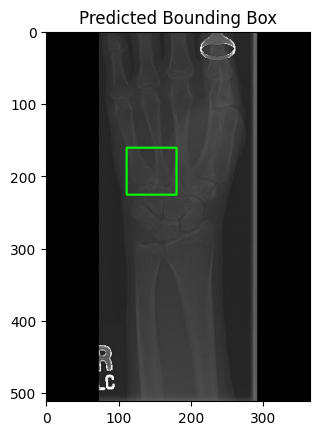

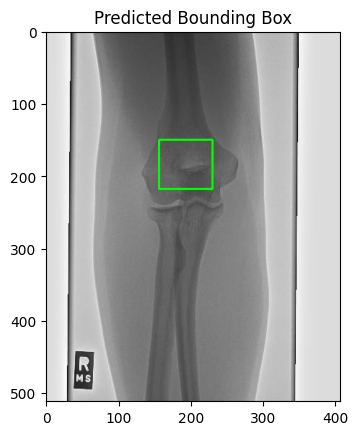

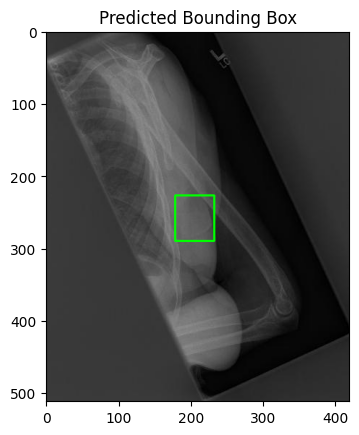

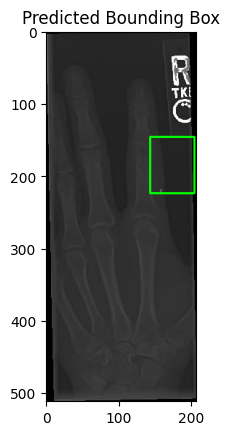

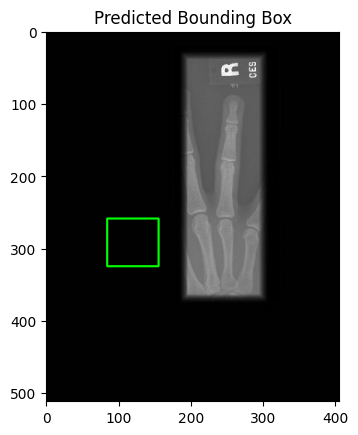

In [ ]:
# Evaluate the model
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error on validation set:", mse)

# Visualize predictions for a few examples
for i in range(5):
    img_path = os.path.join(valid_image_dir, valid_annotations[i]['file_name'])
    if not os.path.exists(img_path):
        continue

    image = cv2.imread(img_path)
    bbox_pred = y_pred[i]

    x, y, w, h = [int(coord) for coord in bbox_pred]
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Bounding Box")
    plt.show()


In [ ]:
# Evaluate the model for fracture detection
def evaluate_accuracy(X, y, model):
    predictions = model.predict(X)
    correct = 0
    total = len(y)

    for i in range(total):
        pred_bbox = predictions[i]
        true_bbox = y[i]

        # Logic to classify as fracture or no fracture
        pred_class = "Fracture" if pred_bbox[2] > 20 and pred_bbox[3] > 20 else "No Fracture"
        true_class = "Fracture" if true_bbox[2] > 20 and true_bbox[3] > 20 else "No Fracture"

        if pred_class == true_class:
            correct += 1

    accuracy = correct / total * 100
    print(f"Model Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate on validation data
evaluate_accuracy(X_valid, y_valid, model)


Model Accuracy: 98.27%


98.26589595375722

In [ ]:
# Function to predict if there's a fracture in a new image
def predict_fracture(image_path, model):
    if not os.path.exists(image_path):
        print(f"Image does not exist: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    features = extract_features(image)  # Extract features using the earlier function
    prediction = model.predict([features])[0]  # Predict using the trained model

    # Interpret the prediction (bounding box size or some logic for fracture/no-fracture)
    if prediction[2] > 20 and prediction[3] > 20:  # Example logic for fracture detection
        print("Prediction: Fracture Detected")
        return "Fracture Detected"
    else:
        print("Prediction: No Fracture Detected")
        return "No Fracture Detected"

# Example usage:
test_image_path = "/image.jpg"  # Updated with the specified path to your test image
result = predict_fracture(test_image_path, model)
print(f"Result for image '{test_image_path}': {result}")


Image does not exist: /image.jpg
Result for image '/image.jpg': None
